In [6]:
pwd

'C:\\Users\\samrb\\Jupyter_notebooks\\options_analysis'

In [2]:
import numpy as np
import scipy
import pandas as pd
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='talk',palette='Paired',rc={'figure.figsize':(20,10)})

file = 'data\\opt_chain_data_fds.xlsx' # FactSet options chain and ATM IV data pull via Excel API to-do is on-demand API or server
eqy_file = 'data\\amzn_opt_chain_data_fds.xlsx'

### current distribution of ATM IV across asset class

In [8]:
atm_vols_raw_df = pd.read_excel(file, sheet_name='ATMIV')

In [9]:
atm_vols_raw_df.columns

Index(['date', 'SPX-SPX', 'EDZ22-USA', 'BRNZ22-IFEU'], dtype='object')

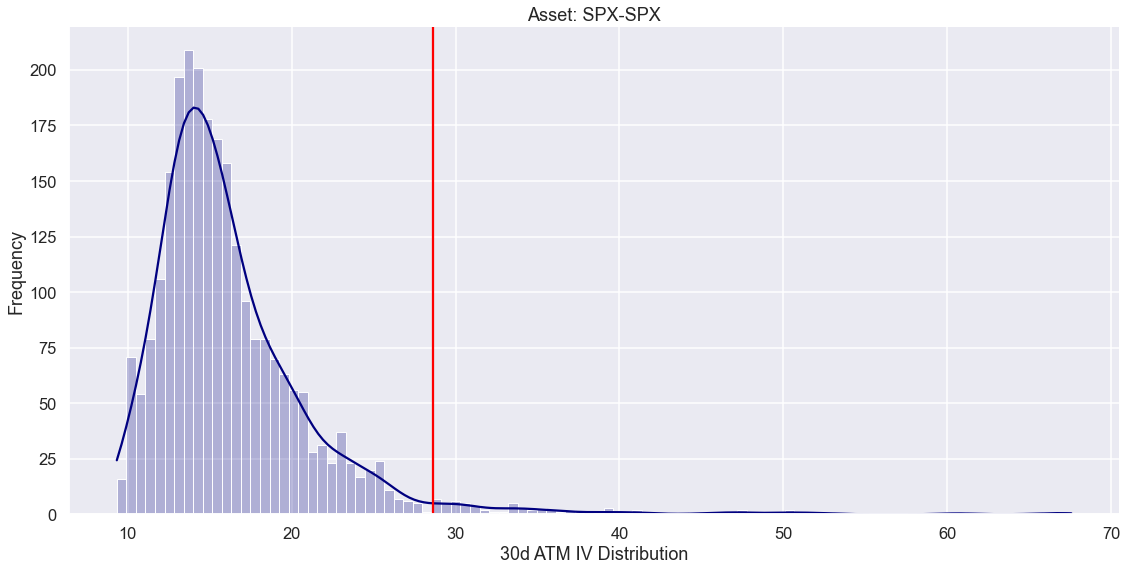

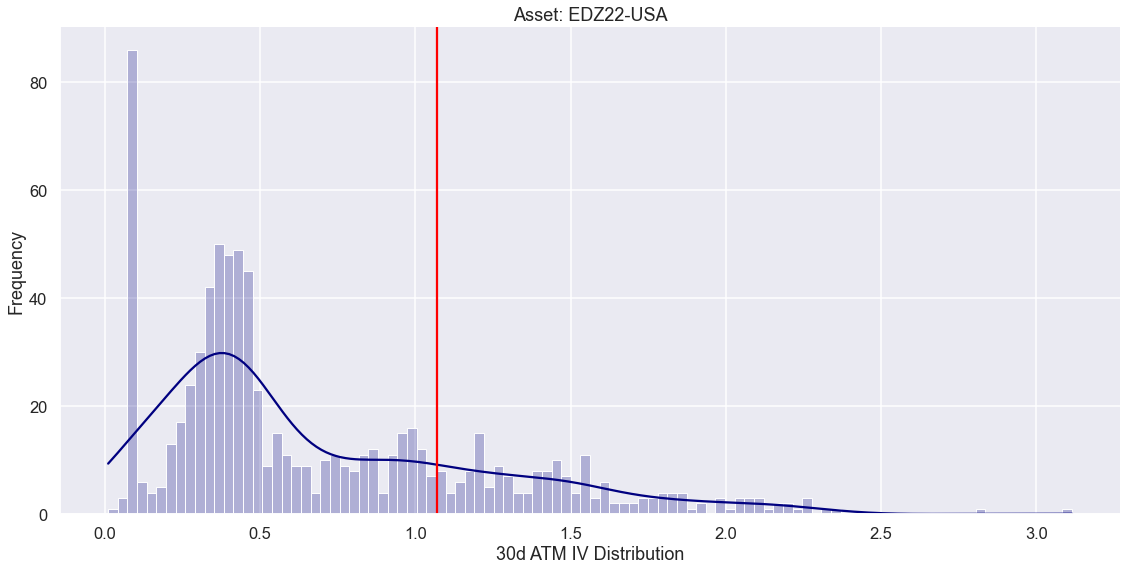

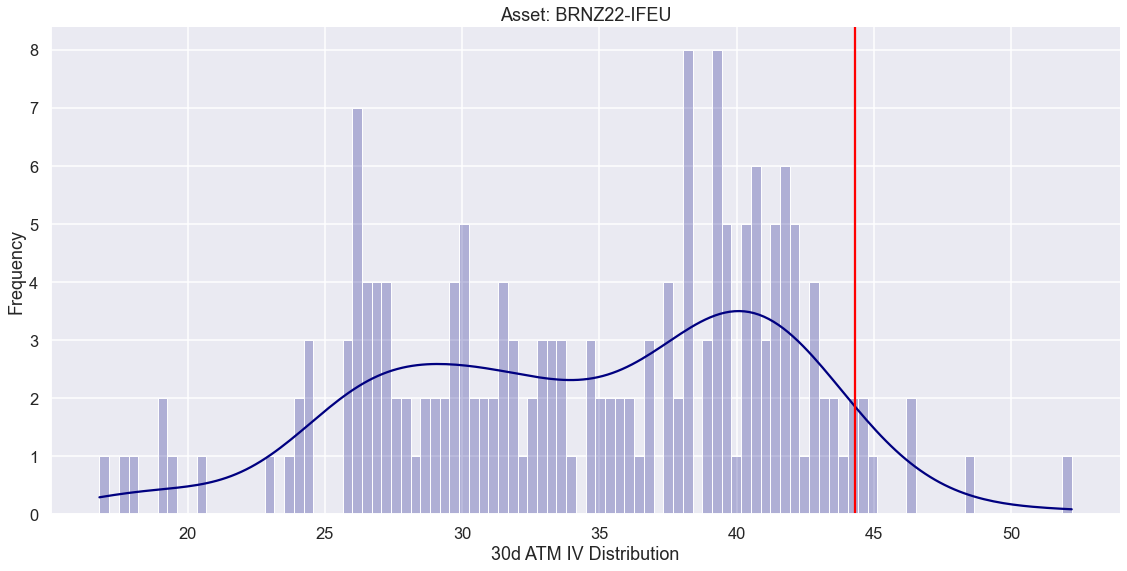

In [10]:
for x in atm_vols_raw_df.set_index('date').columns:
   
    g = sns.displot(data=atm_vols_raw_df.loc[:,x], bins=100,height=8, aspect=2,kde=True,color='navy',alpha=.25)
    g.set(title=f'Asset: {x}',xlabel='30d ATM IV Distribution',ylabel='Frequency')
    plt.axvline(atm_vols_raw_df[x].values[-1], color='r')

# implied price distributions from options markets

In [11]:
# make sure we exclude options expiring on analysis date
today = dt.date.today()
latest_date = pd.to_datetime(today + timedelta(days=-1))
date_range = pd.date_range(start = latest_date+timedelta(days=-365), end=latest_date,freq='W-MON') # for iterative view

In [12]:
spx_data = pd.read_excel(file,sheet_name='spx',skiprows=1)
ed_data = pd.read_excel(file,sheet_name='eurodollar', skiprows=1)
oil_data = pd.read_excel(file, sheet_name='global_oil', skiprows=1)

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [13]:
spx_data.head() # 0 = call, 1 = put

,SPX,PUT_CALL,EXPIRATION,VOLUME,OI,STRIKE,PRICE
0,SPX.SPX#C002L,0,2023-03-17,819,259,4725,189.100
1,SPX.SPX#C0051,0,2022-03-31,0,0,2700,1614.950
2,SPX.SPX#C005W,0,2022-04-29,0,44,5160,0.800
3,SPX.SPX#C0098,0,2023-12-15,0,6,2700,1689.950
4,SPX.SPX#C009J,0,2022-03-09,27,21,4670,0.375


### expiries:

In [14]:
print(f"equities: {spx_data.columns[0]}\n",sorted(pd.to_datetime(spx_data['EXPIRATION'].unique()).strftime('%Y-%m-%d')),"\n------------------")
print(f"eurodollars: {ed_data.columns[0]}\n",sorted(pd.to_datetime(ed_data['EXPIRATION'].unique()).strftime('%Y-%m-%d')),"\n------------------")
print(f"global oil: {oil_data.columns[0]}\n",sorted(pd.to_datetime(oil_data['EXPIRATION'].unique()).strftime('%Y-%m-%d')))

equities: SPX
 ['2022-03-02', '2022-03-04', '2022-03-07', '2022-03-09', '2022-03-11', '2022-03-14', '2022-03-16', '2022-03-18', '2022-03-21', '2022-03-23', '2022-03-25', '2022-03-28', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-08', '2022-04-14', '2022-04-29', '2022-05-20', '2022-05-31', '2022-06-17', '2022-06-30', '2022-07-15', '2022-07-29', '2022-08-19', '2022-08-31', '2022-09-16', '2022-09-30', '2022-10-21', '2022-11-18', '2022-12-16', '2022-12-30', '2023-01-20', '2023-02-17', '2023-03-17', '2023-06-16', '2023-12-15', '2024-12-20', '2025-12-19', '2026-12-18'] 
------------------
eurodollars: EDZ22-USA
 ['2022-03-11', '2022-04-14', '2022-05-13', '2022-12-19'] 
------------------
global oil: BRNZ22-IFEU
 ['2022-10-26']


In [15]:
# config
# option expiration to specify
spx_expire = pd.to_datetime('2022-03-31')
ed_expire = pd.to_datetime('2022-12-19')
oil_expire = pd.to_datetime('2022-10-26')

spx_opt_time = ((spx_expire.date() - latest_date.date()).days)/365
ed_opt_time = ((ed_expire.date() - latest_date.date()).days)/365
oil_opt_time = ((oil_expire.date() - latest_date.date()).days)/365
cutoff = float(.95) # cut out left-tail OTM options

# prices of the underlying
spx_spot = float(pd.read_excel(file,sheet_name='spx').columns.values[1])
ed_spot = float(pd.read_excel(file,sheet_name='eurodollar').columns.values[1]) #edz22
oil_spot = float(pd.read_excel(file,sheet_name='global_oil').columns.values[1]) #cbz22

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [16]:
#### split calls from puts and filter on a given expiry date
spx_calls = spx_data.loc[(spx_data['PUT_CALL'] == 0)
                         & (spx_data['EXPIRATION'] == spx_expire)
                        ].copy().sort_values(by='STRIKE').reset_index(drop=True)
spx_puts  = spx_data.loc[(spx_data['PUT_CALL'] == 1)
                         & (spx_data['EXPIRATION'] == spx_expire)
                        ].copy().sort_values(by='STRIKE').reset_index(drop=True)


ed_calls = ed_data.loc[(ed_data['PUT_CALL'] == 0) 
                       & (ed_data['EXPIRATION'] == ed_expire)
                      ].copy().sort_values(by='STRIKE').reset_index(drop=True)
ed_puts  = ed_data.loc[(ed_data['PUT_CALL'] == 1) 
                       & (ed_data['EXPIRATION'] == ed_expire)
                      ].copy().sort_values(by='STRIKE').reset_index(drop=True)


oil_calls = oil_data.loc[(oil_data['PUT_CALL'] == 0)
                         & (oil_data['EXPIRATION'] == oil_expire)
                        ].copy().sort_values(by='STRIKE').reset_index(drop=True)
oil_puts  = oil_data.loc[(oil_data['PUT_CALL'] == 1)
                         & (oil_data['EXPIRATION'] == oil_expire)
                        ].copy().sort_values(by='STRIKE').reset_index(drop=True)

#### cut out far OTM options -- Equities

In [17]:
spx_calls = spx_calls[(spx_calls['VOLUME']>0)
                      & (spx_calls['OI']>0) 
                      & (spx_calls.STRIKE >= spx_spot*.98) 
                      & (spx_calls.STRIKE<=np.percentile(spx_calls['STRIKE'],95))].copy().reset_index(drop=True)
                    

spx_puts = spx_puts[(spx_puts['VOLUME']>0)
                    & (spx_puts['OI']>0)
                    & (spx_puts.STRIKE <= spx_spot * .98) 
                    & (spx_puts.STRIKE >= np.percentile(spx_puts['STRIKE'],10))].copy().reset_index(drop=True)

## construct probability distribution of implied prices 

$$
\begin{align}
C &= N(d_1) S - N(d_2) Ke^{-rt} \\
P &= - N(-d_1)S + N(-d_2)Ke^{-rt} 
\end{align}
$$

where 

$$
\begin{align}
d_1 &= \frac{1}{\sigma \sqrt{t}}\left[\ln \frac S K + (r + \frac{\sigma^2}{2})t\right] \\
d_2 &=  d_1 - \sigma \sqrt t
\end{align}
$$

In [81]:
def calculate_option_value(S, K, sigma, option, t=0, r=0):
    # use np.multiply and divide to handle divide-by-zero
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
        call = np.multiply(scipy.stats.norm.cdf(d1), S) - np.multiply(scipy.stats.norm.cdf(d2), K * np.exp(-r * t))
        put = np.multiply(scipy.stats.norm.cdf(-d2), K * np.exp(-r * t)) - np.multiply(scipy.stats.norm.cdf(-d1), S) 
    
    if option=='call':
        return call
    elif option=='put':
        return put

In [59]:
 def calculate_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        vega = np.multiply(S, scipy.stats.norm.pdf(d1)) * np.sqrt(t)
    
    return vega

In [50]:
def calculate_bs_iv(option, price, S, K, t=0, r=0, precision=1e-4, initial_guess_iv=0.2, max_iter=1000, verbose=False):
    
    for _ in range(max_iter):
        V = calculate_option_value(S, K, initial_guess_iv,option, t, r)
        diff = price - V
        if abs(diff) < precision:
            return initial_guess_iv
        
        grad = calculate_vega(S, K, initial_guess_iv, t, r)
        iv = initial_guess_iv
        iv += diff / grad     
    if verbose:
        print(f"Did not converge after {max_iter} iterations")
    
    return iv

In [ ]:
def construct_bl_pdf(df, option, S, Krange, t=0, r=0):
    # x is a range of strikes
    
    vol_surface = scipy.interpolate.interp1d(df.STRIKE, df.IV, kind="cubic", fill_value="extrapolate")
    if Krange:
        x_new = Krange
    else:
        x_new = np.arange(df.STRIKE.min(), df.STRIKE.max(), 0.1)
    
    y_new = vol_surface(x_new)
    C_interpolated = calculate_option_value(option, S, x_new, y_new, t,r)
    first_deriv = np.gradient(C_interpolated, x_new, edge_order=0)
    second_deriv = np.gradient(first_deriv, x_new, edge_order=0)
    
    bl_pdf_value = np.exp(r*t) * second_deriv
    
    bl_pdf_value[bl_pdf_value<0] = 0
    
    return bl_pdf_value

In [18]:
def construct_butterfly_pdf(df,option, make_plot=False, fill_value="extrapolate"):
    """
    required three columns and names: VOLUME, OI, and STRIKE
    option = 0 for call, 1 for put
    
    """
    
    if "PRICE" not in df.columns:
        df["PRICE"] = (df.BID + df.ASK) /2
    
    # Construct butterflies
    data = []

    for (_, left) ,(_,center), (_, right) in zip(df.iterrows(), df.iloc[1:].iterrows(), df.iloc[2:].iterrows()):
        # Filter out all zero VOLUME
        if any(vol == 0 for vol in (left.VOLUME, center.VOLUME, right.VOLUME)):
            continue
        # Filter out any zero open interest
        if all(oi == 0 for oi in (left.OI, center.OI, right.OI)):
            continue
        # Equidistant on either end
        if center.STRIKE - left.STRIKE != right.STRIKE - center.STRIKE:
            continue
        butterfly_price = left.PRICE - 2* center.PRICE + right.PRICE
        
        if option == 1:
            max_profit = right.STRIKE - center.STRIKE
        else:
            max_profit = center.STRIKE - left.STRIKE
       
        data.append([center.STRIKE, butterfly_price, max_profit])

    bflys = pd.DataFrame(data, columns=["STRIKE", "PRICE", "PROFIT"])
    bflys["probability"] = bflys.PRICE / bflys.PROFIT

    smoothed_prob = scipy.ndimage.gaussian_filter1d(bflys.probability, 3)
    pdf = scipy.interpolate.interp1d(bflys.STRIKE,
                                     smoothed_prob,
                                     kind="cubic",
                                     fill_value=fill_value)
    if not make_plot:
        x_new = np.linspace(bflys.STRIKE.min(), bflys.STRIKE.max(), 100)
        y_new = pdf(x_new)
        
        return y_new # this is the interpolated shape of the pdf
    
    plt.figure() #figsize=(20,10)
    x_new = np.linspace(bflys.STRIKE.min(), bflys.STRIKE.max(), 100)
    y_new = pdf(x_new)
    
    plt.plot(bflys.STRIKE, smoothed_prob, "rx", x_new, y_new, "k-");
    plt.legend(["smoothed probability", "fitted PDF"], loc="best")
    plt.xlabel("Strike")
    plt.ylabel("f(Strike) - implied probability")

In [82]:
spx_calls['IV'] = spx_calls.apply(lambda x: calculate_bs_iv('call',x.PRICE, spx_spot, x.STRIKE, spx_opt_time), axis=1)

In [83]:
spx_puts['IV'] = spx_puts.apply(lambda x: calculate_bs_iv('put',x.PRICE, spx_spot, x.STRIKE, spx_opt_time), axis=1)

In [125]:
ed_calls['IV'] = ed_calls.apply(lambda x: calculate_bs_iv('call', x.PRICE, ed_spot, x.STRIKE, ed_opt_time, max_iter=1000), axis=1)
ed_puts['IV'] = ed_puts.apply(lambda x: calculate_bs_iv('put', x.PRICE, ed_spot, x.STRIKE, ed_opt_time, max_iter=1000), axis=1)

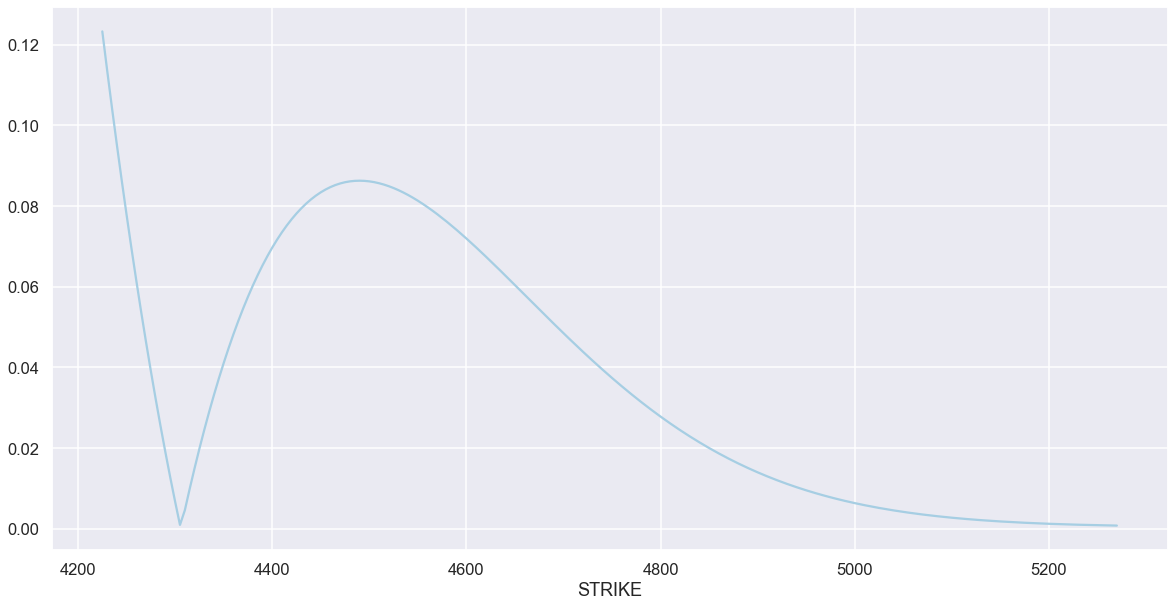

In [121]:
spx_calls.set_index('STRIKE')['IV_2'].plot();

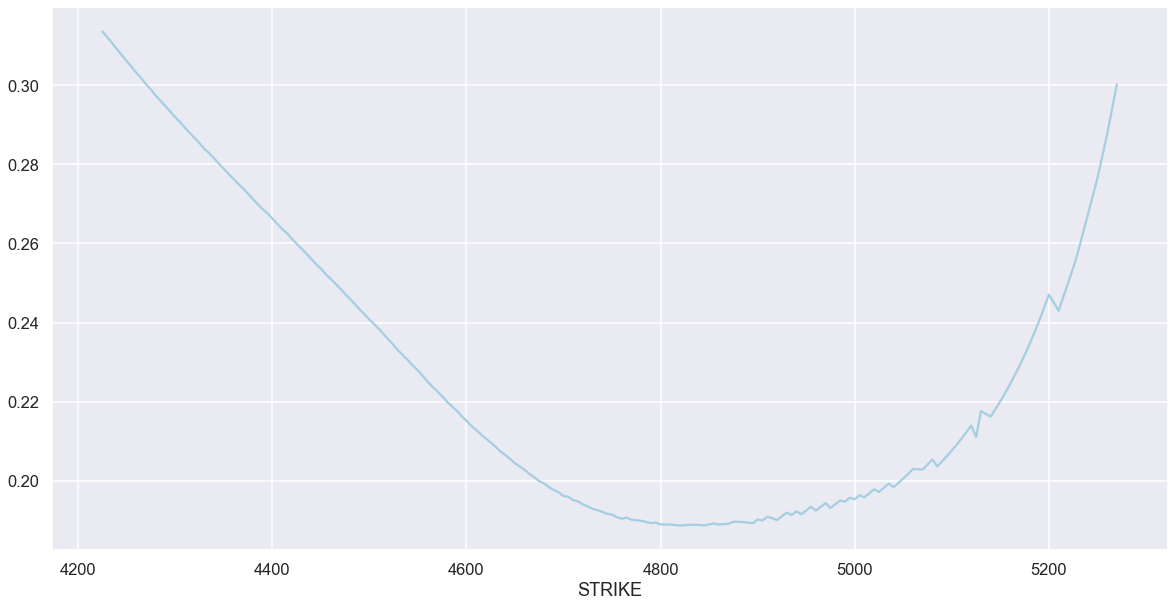

In [84]:
spx_calls.set_index('STRIKE')['IV'].plot();

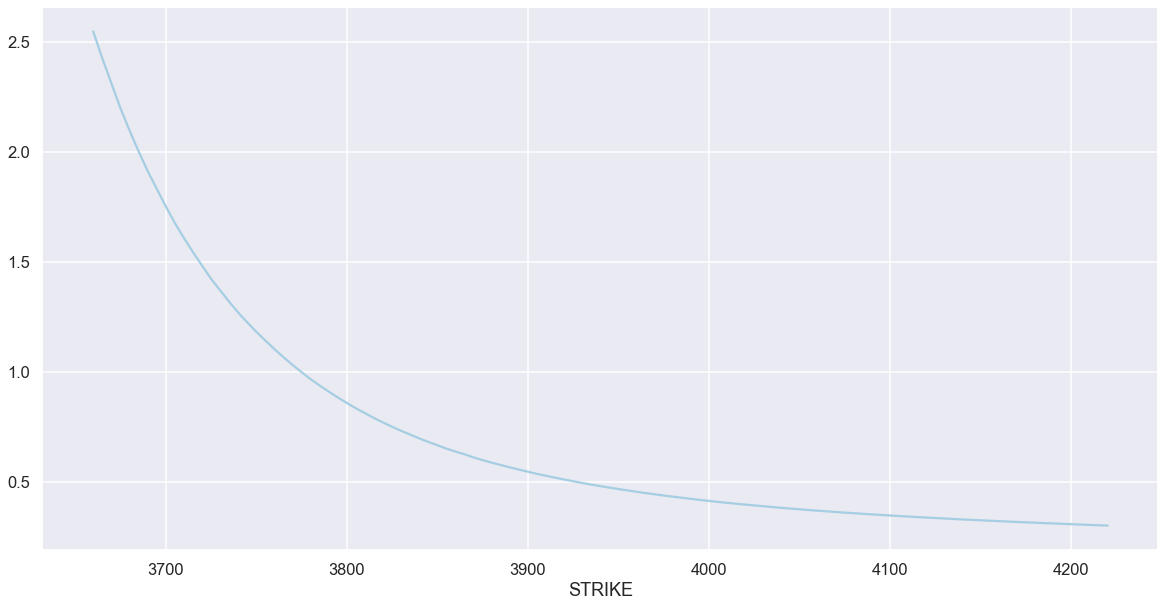

In [113]:
spx_puts[spx_puts['STRIKE']>3650].set_index('STRIKE')['IV'].plot();

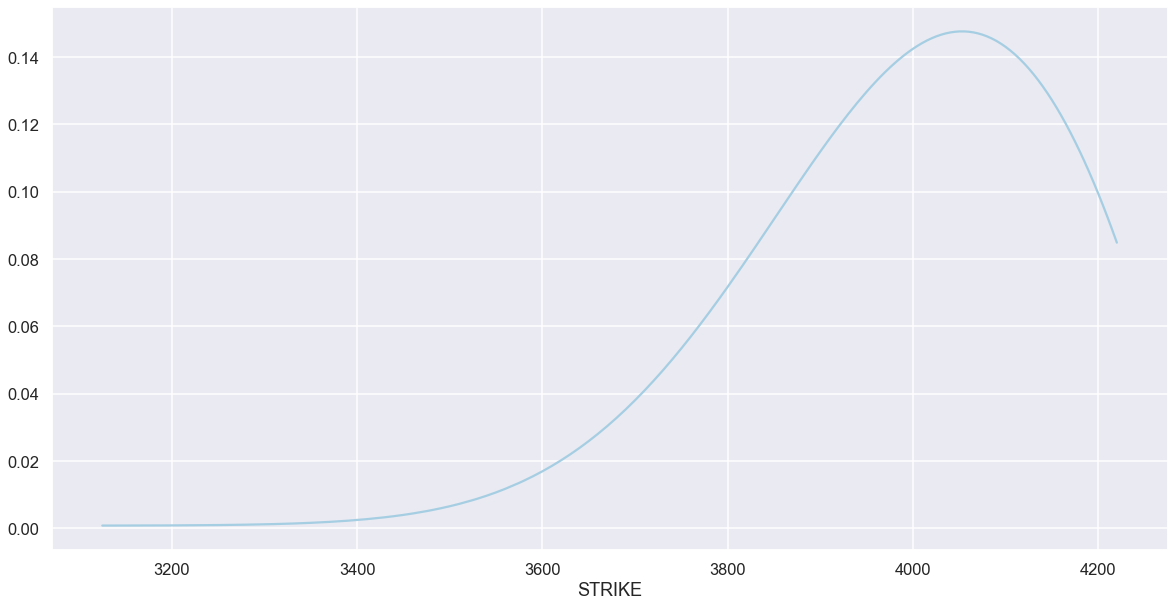

In [122]:
spx_puts.set_index('STRIKE')['IV_2'].plot();